# Identify Person of Interest

## Summary

The Enron scandal, publicized in October 2001, eventually led to the bankruptcy of the Enron Corporation, an American energy company based in Houston, Texas, and the de facto dissolution of Arthur Andersen, which was one of the five largest audit and accountancy partnerships in the world. In addition to being the largest bankruptcy reorganization in American history at that time, Enron was cited as the biggest audit failure. (source: Wikipedia)

In this project, I'm building a person of interest identifier based on financial and email data made public as a result of the Enron scandal and with the help of machine learning techniques. I won't process the data emails_by_address.

Machine Learning allows to predict poi feature. Feature 'poi' is the response variable and it takes value 1 in case of poi and 0 otherwise. A person of Interest is a person who might be involved in the fraud causing the bankruptcy of Enron. This is a classification task. I'll use specifically supervised machine learning since we have a labeled dataset where we know whether or not each datapoint is poi or not.

## Correction needed after review

Creation of a sub folder tools and addition of import
Add imports test_classifier, create_new_features



Amount of code in the report make it hard to follow. have separate sections of code and text explaining the findings of the code. Ex: data analysis is complete but scattered across multiple cells. Difficult to find an explanation of what is tuning or why is it essential.

Understanding the dataset and question 
Move/Add to this section a paragraph discussing the row dimension.
how many data points does it have? how many of each class? are the classes balanced?


Suggestion: there is one more point that can be removed, although it is not an outlier but a useless data point because of lack of data: 

95% of missing data: ['LOCKHART EUGENE E']  

Added paragraph for Tuning: 

what is it? 
search of the best performing model (algorithm + parameters) from a family of models (algorithm)

why is it important?


Suggestion on feature selection/engineering:
univariate or recursive feature selection (selectkbest...)
considering that in most cases your reports will be targeted to non-technical people, it might be beneficial to limit the amount of code and code results you show, and increase the amount of plain english explanation about your findings and decisions. ex: nb of features chosen? threshold?

## Source of the data

The source file enron61702insiderpay.pdf provides the financial data and could be found in this github repository.

The Enron email corpus provide the email data. It is not exploited in this study. 

There are missing values in the dataset. In this case, for a given person if the value of a given feature is missing its value is set to "NaN". When the data is transformed into a numpy array, "NaN" is converted to 0 by default.

## Setup

### Versions:
Package|version
--|--
python|2.7.13
scikit-learn|0.18.1

In [116]:
# Required Libraries
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
sys.path.append("./tools/")
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data, test_classifier
from create_new_features import add_fraction_to_dict
from explore import get_incompletes, display_examples,build_df,display_NaN
#from sklearn.cross_validation import train_test_split for previous versions
from sklearn.model_selection import train_test_split

## Data Exploration

### Dataset Study

-|Feature  | Type | Comment
-|--|--|--
1|bonus|continuous| finance (payment type) feature
2|deferral_payments|continuous| finance (payment type) feature
3|deferred_income|continuous|finance (payment type) feature
4|director_fees|continuous|finance (payment type) feature
5|email_address|nominal|email (text type) feature 
6|exercised_stock_options|continuous|finance (stock type) feature
7|expenses|continuous|finance (payment type) feature
8|from_messages|nominal|email (number of messages) feature 
9|from_poi_to_this_person|continuous|email (number of messages) feature
10|from_this_person_to_poi|continuous|email (number of messages) feature
11|loan_advances|continuous|finance (payment type) feature
12|long_term_incentive|continuous|finance (payment type) feature
13|other|continuous|finance (payment type) feature
14|poi|nominal|the label to identify a person of interest (boolean type)
15|restricted_stock|continuous|finance (stock type) feature
16|restricted_stock_deferred|continuous|finance (stock type) feature
17|salary|continuous|finance (payment type) feature
18|shared_receipt_with_poi|continuous|email (number of messages) feature
19|to_messages|continuous|email (number of messages) feature
20|total_payments|continuous|finance (payment type) feature
21|total_stock_value|continuous|finance (stock type) feature

I will not exploit the feature 'email_address'.

## Task 1: Select what features you'll use.

In [117]:
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi" since it is the target.
features_list = ['poi',
                'bonus',
                'deferral_payments',
                'deferred_income',
                'director_fees',
                'exercised_stock_options',
                'expenses',
                'from_messages',
                'from_poi_to_this_person',
                'from_this_person_to_poi',
                'loan_advances',
                'long_term_incentive',
                'other',
                'restricted_stock',
                'restricted_stock_deferred',
                'salary',
                'shared_receipt_with_poi',
                'to_messages',
                'total_payments',
                'total_stock_value'] 

In [118]:
# counting the number of features
print "number of features", len(features_list)

number of features 20


In [119]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [120]:
print "total number of data points", len(data_dict)

total number of data points 146


## Task 2: Remove outliers

### Outlier Investigation

In [121]:
# Get the list of persons with more than 90% incomplete information
print "\n incompletes more than 90% incomplete information:\n",get_incompletes(data_dict,0.9)


 incompletes more than 90% incomplete information:
90.4761904762  %
90.4761904762  %
100.0  %
90.4761904762  %
90.4761904762  %
['WHALEY DAVID A', 'WROBEL BRUCE', 'LOCKHART EUGENE E', 'THE TRAVEL AGENCY IN THE PARK', 'GRAMM WENDY L']


In [122]:
display_examples(data_dict)

Name: TOTAL
[ poi ] =  False
Name: TOTAL
[ bonus ] =  97343619
Name: TOTAL
[ salary ] =  26704229
Name: THE TRAVEL AGENCY IN THE PARK
[ poi ] =  False
Name: THE TRAVEL AGENCY IN THE PARK
[ bonus ] =  NaN
Name: THE TRAVEL AGENCY IN THE PARK
[ salary ] =  NaN

Who has the highest salary? 
TOTAL

Who has the highest bonus? 
TOTAL


Let's display the graph "Bonus vs Salary". A clear outlier is appearing.

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
sns.set_style('whitegrid')
plt.style.use('classic')

![Diagram](Outlier_TOTAL.jpg)

The outlier is caught by looking for the highest bonus and highest salary. 

The salary is 26,704,229

The bonus is 97,343,619

poi value is 0

The name "TOTAL" is a hint that it is not a person but the sum of financial features. 

It has to be discarded. 

In [124]:
# removing the outlier called TOTAL
data_dict.pop( "TOTAL", 0 );
# not a person and many missing information above 90%
data_dict.pop( "THE TRAVEL AGENCY IN THE PARK", 0 );
# no information at all for LOCKHART EUGENE E
data_dict.pop( "LOCKHART EUGENE E",0);

In [125]:
df = build_df(data_dict)

After removal, we have the following graph:

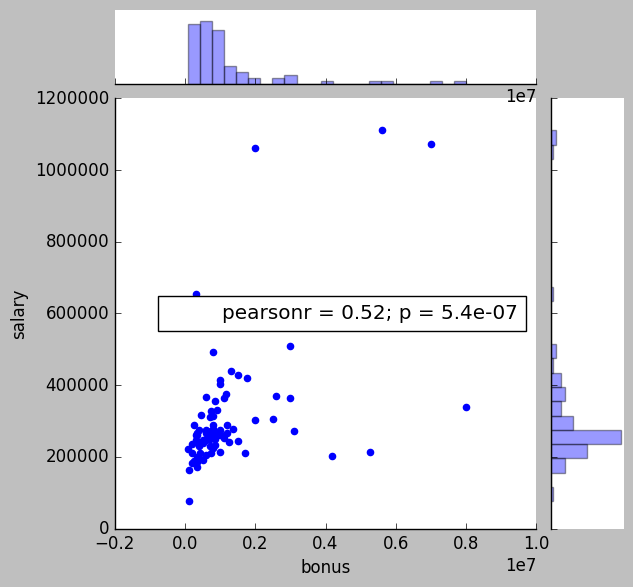

In [126]:
sns.jointplot(x="bonus", y="salary", data=df)
plt.show()

In [127]:
print "total number of data points", len(data_dict)

total number of data points 143


In [128]:
### Checking the target class
count_poi = pd.value_counts(df['poi'], sort = True).sort_index()
print "number of poi:\n",count_poi

number of poi:
False    125
True      18
Name: poi, dtype: int64


In [129]:
## Percentage of POI:
print "Percentage of POI ",100*18./143,"%"

Percentage of POI  12.5874125874 %


## Task 3: Create new feature(s)

### Direction:
Create new feature(s)

The two created features are related to ratios of emails sent to or from POI. It shows for that person what is the proportion of emails echanged with poi. It shows how intense are echanges with POI regardless of the volume of emails.   

In [130]:
add_fraction_to_dict(data_dict, "perc_from_poi", "from_poi_to_this_person", "to_messages")
add_fraction_to_dict(data_dict, "perc_to_poi", "from_this_person_to_poi", "from_messages")

perc_from_poi  = [data_dict[key]['perc_from_poi'] for key in data_dict.keys()]
perc_to_poi  = [data_dict[key]['perc_to_poi'] for key in data_dict.keys()]

df['perc_from_poi'] = perc_from_poi
df['perc_to_poi'] = perc_to_poi

![Diagram](perc_from_poiVSperc_to_poi.png)

## Missing Values

We could consider that if a person did not receive any financial retribution, its value is zero.

My choice is that NaN values have to be replaced by zeros.

For the same reason, for email features, NaN values have to be replaced by zeros.

In [133]:
display_NaN(df)

% of NaN values for  name 0.00
% of NaN values for  poi 0.00
% of NaN values for  bonus 43.36
% of NaN values for  deferral_payments 73.43
% of NaN values for  deferred_income 66.43
% of NaN values for  director_fees 88.81
% of NaN values for  exercised_stock_options 29.37
% of NaN values for  expenses 34.27
% of NaN values for  loan_advances 97.90
% of NaN values for  long_term_incentive 54.55
% of NaN values for  other 36.36
% of NaN values for  restricted_stock 23.78
% of NaN values for  restricted_stock_deferred 88.11
% of NaN values for  salary 34.27
% of NaN values for  total_payments 13.99
% of NaN values for  total_stock_value 12.59
% of NaN values for  from_messages 39.86
% of NaN values for  from_poi_to_this_person 39.86
% of NaN values for  from_this_person_to_poi 39.86
% of NaN values for  shared_receipt_with_poi 39.86
% of NaN values for  to_messages 39.86
% of NaN values for  perc_from_poi 0.00
% of NaN values for  perc_to_poi 0.00


Some features have not enough information: 
loan_advances (97.92% of NaN), 
director_fees (88.89% of NaN), 
restricted_stock_deferred (88.19% of NaN),
deferral_payments (73.61% of NaN),

For this reason, I do not include them in feature selection.

In [134]:
# Missing values : do not include these features
df.drop("loan_advances", axis=1,inplace=True)
df.drop("restricted_stock_deferred",axis=1,inplace=True)
df.drop("director_fees",axis=1,inplace=True)
df.drop("deferral_payments",axis=1,inplace=True)            

![Diagram](PearsonCorrelationOfFeatures.png)

__Linear Correlation deduced from Pearson's Correlation Diagram:__

shared_receipt_with_poi and to_messages have a strong linear relationship (increasing).

exercised_stock_options and total_stock_value have a strong linear relationship (increasing). It is not a surprise. 

Others and total_payment have a strong linear relationship (increasing).

Exercised_stock_options and Restricted stock have a linear relationship (increasing).

In [135]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [136]:
# 17 features in total
features_list = ['poi',
                 'bonus',
                 'deferred_income',
                 'exercised_stock_options',
                 'expenses',
                 'long_term_incentive',
                 'other',
                 'restricted_stock',
                 'salary',
                 'total_payments',
                 'total_stock_value',
                 'from_messages',
                 'from_poi_to_this_person',
                 'from_this_person_to_poi',
                 'shared_receipt_with_poi',
                 'to_messages',
                 'perc_from_poi',
                 'perc_to_poi']

In [137]:
### Store to my_dataset for easy export below.
my_dataset = data_dict

In [138]:
### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

In [139]:
### split data into training and testing datasets
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.1, random_state=42)

print("Number train dataset: ", len(features_train))
print("Number test dataset: ", len(features_test))
print("Total number: ", len(features_train)+len(features_test))

('Number train dataset: ', 128)
('Number test dataset: ', 15)
('Total number: ', 143)


In [140]:
corr_matrix = df.corr()

In [141]:
corr_matrix["poi"].sort_values(ascending=False)

poi                        1.000000
exercised_stock_options    0.503551
total_stock_value          0.366462
perc_to_poi                0.322875
bonus                      0.302384
salary                     0.264976
long_term_incentive        0.254723
total_payments             0.230102
shared_receipt_with_poi    0.228313
restricted_stock           0.224814
from_poi_to_this_person    0.167722
perc_from_poi              0.147321
other                      0.120270
from_this_person_to_poi    0.112940
expenses                   0.060292
to_messages                0.058954
from_messages             -0.074308
deferred_income           -0.265698
Name: poi, dtype: float64

## Prepare the data for Machine Learning algorithms

### Feature scaling

I did not have to do any scaling.

Naive Bayes, as well as Decision trees and Tree-based ensemble methods (RF, XGB) are invariant to feature scaling.

Thus, I did not used feature scaling. 

Affected algorithms are for example: SVM, 

### Selection of features and use of SelectKBest

![Diagram](FeatureImportance.png)

__Reminder of correlated features:__

shared_receipt_with_poi and to_messages have a strong linear relationship (increasing).

exercised_stock_options and total_stock_value have a strong linear relationship (increasing).

Others and total_payment have a strong linear relationship (increasing).

Exercised_stock_options and Restricted stock have a linear relationship (increasing).

In [142]:
# select best features from kbest
features_list = ['poi',
                'exercised_stock_options',
                'total_stock_value',
                'bonus',
                'salary',
                'perc_to_poi',
                'deferred_income',
                'long_term_incentive',
                'restricted_stock',
                'total_payments',
                'shared_receipt_with_poi',
                'expenses',
                'from_poi_to_this_person',
                'other',
                'perc_from_poi',
                'from_this_person_to_poi',
                'to_messages',
                'from_messages']

In [143]:
# select best features and getting rid of correlated features: 13 are remaining in total
features_list = ['poi',
                'exercised_stock_options',
                'bonus',
                'salary',
                'perc_to_poi',
                'deferred_income',
                'long_term_incentive',
                'total_payments',
                'shared_receipt_with_poi',
                'expenses',
                'from_poi_to_this_person',
                'perc_from_poi',
                'from_this_person_to_poi',
                'from_messages']

In [144]:
### Store to my_dataset for easy export below.
my_dataset = data_dict

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

In [145]:
### split data into training and testing datasets
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.1, random_state=42)

print("Number train dataset: ", len(features_train))
print("Number test dataset: ", len(features_test))
print("Total number: ", len(features_train)+len(features_test))

('Number train dataset: ', 127)
('Number test dataset: ', 15)
('Total number: ', 142)


## Task 4: Try a varity of classifiers

### Direction:
Try a varity of classifiers

Please name your classifier clf for easy export below.

Note that if you want to do PCA or other multi-stage operations,
you'll need to use Pipelines. For more info:
http://scikit-learn.org/stable/modules/pipeline.html

### Naive Bayes Model

In [146]:
### trial with Naive Bayes for prediction
from sklearn.naive_bayes import GaussianNB

nb_clf = GaussianNB()
nb_clf.fit(features_train, labels_train)

GaussianNB(priors=None)

In [147]:
test_classifier(nb_clf, my_dataset, features_list)

GaussianNB(priors=None)
	Accuracy: 0.83993	Precision: 0.37073	Recall: 0.28750	F1: 0.32385	F2: 0.30102
	Total predictions: 15000	True positives:  575	False positives:  976	False negatives: 1425	True negatives: 12024



### Decision Tree Model

In [148]:
from sklearn.tree import DecisionTreeClassifier

DTree_clf = DecisionTreeClassifier(random_state=42)
DTree_clf.fit(features_train,labels_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [149]:
test_classifier(DTree_clf, my_dataset, features_list)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')
	Accuracy: 0.81713	Precision: 0.30701	Recall: 0.29550	F1: 0.30115	F2: 0.29773
	Total predictions: 15000	True positives:  591	False positives: 1334	False negatives: 1409	True negatives: 11666



In [150]:
print "Feature importances:",DTree_clf.feature_importances_
print "The number of classes ",DTree_clf.n_classes_

Feature importances: [ 0.06620183  0.          0.04767267  0.17102017  0.05720721  0.02026089
  0.06674174  0.2240468   0.21336521  0.08581081  0.          0.04767267
  0.        ]
The number of classes  2


In [151]:
from sklearn import tree 
dot_data = tree.export_graphviz(DTree_clf,
                                feature_names=features_list[1:],
                                class_names=True,
                                label='all',
                                filled=True, rounded=True,
                                out_file="tree.dot")

In [152]:
# Use commands for generating image DecisionTree01.png
# >activate DAND
# >cd "~/final_project" # where the tree.dot is located
# >dot -Tpng tree.dot -o DecisionTree01.png

![Diagram](DecisionTree01.png)

### Random Forest Model

In [153]:
from sklearn.ensemble import RandomForestClassifier

RF_clf = RandomForestClassifier(criterion='entropy',max_features=1,
                             random_state=42)
RF_clf.fit(features_train, labels_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=1, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [154]:
test_classifier(RF_clf, my_dataset, features_list)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=1, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
	Accuracy: 0.86327	Precision: 0.44218	Recall: 0.09750	F1: 0.15977	F2: 0.11551
	Total predictions: 15000	True positives:  195	False positives:  246	False negatives: 1805	True negatives: 12754



In [155]:
print "Feature importances:",RF_clf.feature_importances_

Feature importances: [ 0.16600026  0.06917332  0.07329676  0.14227899  0.0484351   0.10840532
  0.09809793  0.04676382  0.08431206  0.03344624  0.05901818  0.02555952
  0.04521251]


### Adaboost Model

In [156]:
from sklearn.ensemble import AdaBoostClassifier
depth = 10
aboost_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=depth),
                         algorithm="SAMME")    
aboost_clf.fit(features_train,labels_train)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None)

In [157]:
test_classifier(aboost_clf, my_dataset, features_list)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None)
	Accuracy: 0.81860	Precision: 0.31195	Recall: 0.29900	F1: 0.30534	F2: 0.30150
	Total predictions: 15000	True positives:  598	False positives: 1319	False negatives: 1402	True negatives: 11681



In [158]:
print "Feature importances:",aboost_clf.feature_importances_

Feature importances: [ 0.06620183  0.          0.          0.17102017  0.          0.1060717
  0.16208709  0.2240468   0.21336521  0.          0.          0.05720721
  0.        ]


## Task 5: Tune your classifier to achieve better than .3 precision and recall

#### Direction:
Tune your classifier to achieve better than .3 precision and recall 
using our testing script. Check the tester.py script in the final project
folder for details on the evaluation method, especially the test_classifier
function. 

Because of the small size of the dataset, the script uses
stratified shuffle split cross validation. 
For more info: 
http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

### Tuning

Careful: model parameters <> hyperparameters.

Once the selection of the model is done, tuning consists in finding the algorithm parameters - hyperparameters - to fit the model to the training set - i.e. to make good predictions on the training set itself - and generalization.
Example of hyperparameters: TBD
Tuning helps to get more accurate machine learning models.

The model parameters are learned during training - e.g linear regression. 

Hyperparameters are set by the Data Analyst.

When there are many hyperparameters, tuning could be tedious. In this case, it is intersting to adopt TBD. this automation method is cost effective: you save time.

It is important to fine-tune the model since we want the best performance (e.g. minimal errors, best accuracy, and so on).

Random Forest case:
max_features: 

___General Tuning techniques:___
- try a smaller set of features

Good when overfitting. Used here below

- try getting additional features. 

Not used at this stage.

- try increasing and decreasing λ (Change how important the regularization term). 

It is helpful (e.g. logistic regression) but I did not select this method given the models used.

- play with model parameters - hyperparameters.

Use of automatic search of best hyperparameters. Used here below

### NaiveBayes Model

In [159]:
# There is no parameters for Naive Bayes except playing with the number of features. 
# scores to beat: Accuracy: 0.83993	Precision: 0.37073	Recall: 0.28750	F1: 0.32385	F2: 0.30102

In [160]:
# Tuning: 
# select One feature only: better performance when reducing the number of features
features_list = ['poi','exercised_stock_options']

In [161]:
### Naive Bayes for prediction
nb_clf = GaussianNB()
nb_clf.fit(features_train, labels_train)

GaussianNB(priors=None)

In [162]:
## Evaluation on the final model
test_classifier(nb_clf, my_dataset, features_list)

GaussianNB(priors=None)
	Accuracy: 0.90409	Precision: 0.46055	Recall: 0.32100	F1: 0.37831	F2: 0.34171
	Total predictions: 11000	True positives:  321	False positives:  376	False negatives:  679	True negatives: 9624



## DecisionTreeClassifier

In [163]:
# Feature importances: [ 0.06620183,0.,0.04767267,0.17102017,0.05720721,0.02026089,0.06674174,
#0.2240468,0.21336521,0.08581081,0.,0.04767267,0.] from previous run of Decision Tree
# scores to beat: Accuracy: 0.81713	Precision: 0.30701	Recall: 0.29550	F1: 0.30115	F2: 0.29773

In [164]:
# Tuning:
# select the 9 most important features from last run of DecisionTreeClassifier
# Use of feature importances
features_list = ['poi',
                'exercised_stock_options',
                'salary',
                'perc_to_poi',
                'deferred_income',
                'total_payments',
                'shared_receipt_with_poi',
                'expenses',
                'from_poi_to_this_person',
                'from_this_person_to_poi']

In [165]:
from sklearn.model_selection import GridSearchCV

In [166]:
# Tuning with the following hyperparameters: 
# criterion, max_depth, min_samples_split, max_features 
param_grid = {'criterion': ["entropy"],
              'max_depth':[2,5,10],
              'min_samples_split':[2,3,4,5],
              'max_features': [1,2,3,4,5,6,7,8,9],
              'random_state':[42]}
DTree_clf = DecisionTreeClassifier()
#  F1 as scoring since the recall and the precision are equally important.
grid_search = GridSearchCV(DTree_clf, param_grid, cv=10, verbose=1, n_jobs=1,scoring='f1')
grid_search.fit(features_train, labels_train)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed:    3.3s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2, 3, 4, 5], 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'random_state': [42], 'criterion': ['entropy'], 'max_depth': [2, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=1)

In [167]:
# Best hyperparameters
grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 2,
 'max_features': 8,
 'min_samples_split': 2,
 'random_state': 42}

In [168]:
# Best Estimator
DTree_clf = grid_search.best_estimator_

In [169]:
grid_search.best_score_

0.60341207349081361

In [170]:
# reuse of best estimator
DTree_clf.fit(features_train, labels_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
            max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')

In [171]:
## Evaluation on the final model
test_classifier(DTree_clf, my_dataset, features_list)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
            max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')
	Accuracy: 0.83993	Precision: 0.41938	Recall: 0.52150	F1: 0.46490	F2: 0.49728
	Total predictions: 15000	True positives: 1043	False positives: 1444	False negatives:  957	True negatives: 11556



In [172]:
print "Feature importances:",DTree_clf.feature_importances_
print "The number of classes ",DTree_clf.n_classes_

Feature importances: [ 0.          0.          0.40274157  0.          0.          0.
  0.59725843  0.          0.        ]
The number of classes  2


In [173]:
dot_data = tree.export_graphviz(DTree_clf,
                                feature_names=features_list[1:],
                                class_names=True,
                                label='all',
                                filled=True, rounded=True,
                                out_file="tree2.dot")

In [174]:
# Use commands to generate image file DecisionTree02.png 
# >activate DAND
# >cd "~/final_project" # where the tree2.dot is located
# >dot -Tpng tree2.dot -o DecisionTree02.png

![Diagram](DecisionTree02.png)

## RandomForestClassifier

In [175]:
# Accuracy to beat: Accuracy: 0.86247	Precision: 0.43907	Recall: 0.11350	F1: 0.18037	F2: 0.13326

Feature importances from the previous run of Random Forest: 
[ 0.16600026  0.06917332  0.07329676  0.14227899  0.0484351   0.10840532
  0.09809793  0.04676382  0.08431206  0.03344624  0.05901818  0.02555952
  0.04521251]

In [176]:
# Tuning: 
# Select the most important features from last run of Random Forest
# reducing the number of features from 9 to 2 since the performance was not sifficient
# selecting feature 'bonus' instead of 'perc_to_poi' for better performance 
features_list = ['poi',
                'exercised_stock_options',
                'bonus']

In [177]:
# Tuning with the following hyperparameters: 
# criterion, n_estimators, max_depth, max_features 
param_grid = {'criterion': ["gini", "entropy"],
              'n_estimators':[2,3,4,5],
              'max_depth':[None,5,10,15],
              'max_features': [None,1,2],
              'random_state':[42]}
RF_clf = RandomForestClassifier()
#  F1 as scoring since the recall and the precision are equally important.
grid_search = GridSearchCV(RF_clf, param_grid, cv=10, verbose=1, n_jobs=1,scoring='f1')
grid_search.fit(features_train, labels_train)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=1)]: Done 960 out of 960 | elapsed:   12.0s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [2, 3, 4, 5], 'max_features': [None, 1, 2], 'random_state': [42], 'criterion': ['gini', 'entropy'], 'max_depth': [None, 5, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=1)

In [178]:
# Best hyperparameters
grid_search.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'n_estimators': 3,
 'random_state': 42}

In [179]:
# Best estimator
RF_clf = grid_search.best_estimator_

In [180]:
grid_search.best_score_

0.48477690288713909

In [181]:
# Reuse of the best estimator
RF_clf.fit(features_train, labels_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=3, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [182]:
## Evaluation on the final model
test_classifier(RF_clf, my_dataset, features_list)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=3, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
	Accuracy: 0.81754	Precision: 0.40663	Recall: 0.40500	F1: 0.40581	F2: 0.40532
	Total predictions: 13000	True positives:  810	False positives: 1182	False negatives: 1190	True negatives: 9818



### Adaboost Model

The scores to beat from last run of Adaboost model: Accuracy: 0.81860	Precision: 0.31195	Recall: 0.29900	F1: 0.30534	F2: 0.30150 

Feature importances from previous run of Adaboost: 

[ 0.06620183 , 0., 0., 0.17102017, 0., 0.1060717, 0.16208709, 0.2240468, 0.21336521, 0., 0., 0.05720721, 0.]

In [183]:
# Tuning:
# select best features and using feature importance from last run of Adaboost 
features_list = ['poi',
                'exercised_stock_options',
                'perc_to_poi',
                'long_term_incentive',
                'total_payments',
                'shared_receipt_with_poi',
                'expenses',
                'from_this_person_to_poi']

In [184]:
# Tuning with the following hyperparameters: 
# n_estimators, algorithm, learning_rage 
param_grid = {'n_estimators':[2,3,4,5,10],
              'algorithm':['SAMME'],
              'learning_rate':[0.5,1,2],
              'random_state':[42]}
Aboost_clf = AdaBoostClassifier()
#  F1 as scoring since the recall and the precision are equally important.
grid_search = GridSearchCV(Aboost_clf, param_grid, cv=10, verbose=1, n_jobs=1,scoring='f1')
grid_search.fit(features_train, labels_train)

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    2.0s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [2, 3, 4, 5, 10], 'learning_rate': [0.5, 1, 2], 'random_state': [42], 'algorithm': ['SAMME']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=1)

In [185]:
# Best hyperparameters 
grid_search.best_params_

{'algorithm': 'SAMME',
 'learning_rate': 1,
 'n_estimators': 3,
 'random_state': 42}

In [186]:
# Best estimator
clf = grid_search.best_estimator_

In [187]:
# reuse of the best estimator
clf.fit(features_train,labels_train)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=1,
          n_estimators=3, random_state=42)

In [188]:
## Evaluation on the final model
test_classifier(clf, my_dataset, features_list)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=1,
          n_estimators=3, random_state=42)
	Accuracy: 0.87213	Precision: 0.51576	Recall: 0.67100	F1: 0.58322	F2: 0.63290
	Total predictions: 15000	True positives: 1342	False positives: 1260	False negatives:  658	True negatives: 11740



### Task 6

### Direction 

Dump your classifier, dataset, and features_list so anyone can
check your results. You do not need to change anything below, but make sure
that the version of poi_id.py that you submit can be run on its own and
generates the necessary .pkl files for validating your results.

See: poi_id.py file

## Validation

__Usage of Evaluation Metrics__

In case of classification problems and when the dataset is unbalanced - i.e. a difference in the numbers of positive and negative instances, usually with the negatives outnumbering the positives - the most appropriate metric is not accuracy but some alternate metrics (precision, recall).

Accuracy in classification problems is the number of correct predictions made by the model over all kinds predictions made.

The meaning of precision is the following: a precision of 0.3 means that there are 30% correct predictions among the positive predictions. Precision is a measure that tells us what proportion of people that we predicted as being poi, actually are poi.

Recall is a measure that tells us what proportion of people that actually are poi was predicted by the algorithm as being poi.

Here is an example with RandomForest Classifier with an imbalanced dataset:

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=1, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
            
__Accuracy: 0.86327	Precision: 0.44218	Recall: 0.09750	F1: 0.15977	F2: 0.11551__

__Total predictions: 15000	True positives:  195	False positives:  246	False negatives: 1805	True negatives: 12754__

The key point is that accuracy metric fails to capture the poor performance of the classifier for the imbalanced dataset. For example, accuracy indicates that the performance of the classifier is fine with 0.86. But the recall (respectively precision)  indicates that the performance of the classifier is relatively poor (respectively acceptable) on the imbalanced dataset with 0.10 (respectively with 0.44). Hence, precision and recall reveal differences in performance that go unnoticed when using accuracy.

For GridSearchCV, I use F1 as scoring since the recall and the precision are equally important.

__Validation and its importance__

Validation is to ensure that the model could generalise well. For that purpose the dataset is to split the data into 2 sets: training set and test set. 

Cross-validation was used here. The concept is the following: Instead of using the whole dataset to train and then test on same data, I randomly divide our data into training and testing datasets.

If validation is not performed correctly, when the model is deployed into production it is highly probable that with new data the performance will drop since the model could not generalise well.

__Algorithm Performance__

The algorithm is validated when precision and recall are both at least 0.3

Algorithm|Accuracy|Precision|Recall|F1
--|--|--|--|--|--
NaiveBayes|0.90409|0.46055|0.32100|0.3783
DecisionTree|0.83993|0.41938|0.52150|0.46490
RandomForestClassifier|0.81754|0.40663|0.40500|0.40581
AdaBoostClassifier|0.87213|0.51576|0.67100|0.58322

When tester.py is used to evaluate performance, precision and recall are both at least 0.3.

## Conclusion

The dataset is very small. And data matters as well as algorithm.

Two Outliers have been removed with significant impact.

New features have been added (e.g. perc_to_poi) and for some models it was efficient. The feature perc_to_poi is the second highest significant feature for Adaboost Model (selected model). The feature perc_to_poi is highly significant for the tuned Decision Tree model.

Relevant data have been used. When using all the features, models performed poorly because of overfitting in some cases. A good approach was to use a smaller set of features.

There was no way to have more training data.

The key influencing features are financial ones (e.g. exercised_stock_options)

Some features have very few information: loan_advances, director_fees, restricted_stock_deferred. The approach was to not include them in feature selection.

Tuning could be time consuming and specially if done manually. It's why the use of GridSearch helped a lot.

The selected model is AdaBoost with the following scores:

Accuracy: 0.87213	

Precision: 0.51576	

Recall: 0.67100	


## Documentation/References

[GitHub repository 1]

https://github.com/ageron/handson-ml

[GitHub repository 2]

https://github.com/MarcCollado/Enron

[GitHub repository 3]

https://github.com/travisseal/enron_data_udacity

[GitHub repository 4]

https://github.com/Jacobdudee/EnronModel

[GitHub repository 5]

https://github.com/adazamora/enron_ml/blob/master/ml_project.ipynb

[Hdbk] Python for Data Science Handbook from Blog:
[blog](http://www.datasciencecentral.com/profiles/blogs/book-python-data-science-handbook?utm_content=buffer09a5c&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer)